<a href="https://www.kaggle.com/code/rishitabansal/amex-credit-card-default-prediction?scriptVersionId=120728599" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasetforamericanexpress/DataSights_Dataset.csv


# 1. Preliminary Data Analysis

## 1.1 Importing the libraries

In [2]:
#importing and pre-processing data
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler 
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_selector

#visualizing data
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#training data 
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb 
import lightgbm as ltb

#checking models accuracy
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

## 1.2 Dataset

In [3]:
df=pd.read_csv("/kaggle/input/datasetforamericanexpress/DataSights_Dataset.csv")
df.head()

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,CST_115179,ita Bose,46,F,N,Y,0.0,107934.04,612.0,Unknown,1.0,1.0,33070.28,18690.93,73,544.0,2,1,1
1,CST_121920,Alper Jonathan,29,M,N,Y,0.0,109862.62,2771.0,Laborers,2.0,0.0,15329.53,37745.19,52,857.0,0,0,0
2,CST_109330,Umesh Desai,37,M,N,Y,0.0,230153.17,204.0,Laborers,2.0,0.0,48416.60,41598.36,43,650.0,0,0,0
3,CST_128288,Rie,39,F,N,Y,0.0,122325.82,11941.0,Core staff,2.0,0.0,22574.36,32627.76,20,754.0,0,0,0
4,CST_151355,McCool,46,M,Y,Y,0.0,387286.00,1459.0,Core staff,1.0,0.0,38282.95,52950.64,75,927.0,0,0,0


We should make certain changes to _**customer_id**_ column:
  * Strip the str to make it an integer column for easy data processing.
  * Set it as index because it contains unique values and is not of much use in predicting the outcome.
  * Sort values according to the index.

### 1.2.1 Assigning index to the dataset.

In [4]:
df['customer_id']=df['customer_id'].str.replace('CST_', '')
df = df.set_index('customer_id')
df=df.sort_index()
df.head()

,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
customer_id,,,,,,,,,,,,,,,,,,
100002,Aaron Gray-Block,38,M,N,Y,0.0,222274.96,640.0,Laborers,1.0,0.0,27216.28,79364.33,81,688.0,0,0,1
100003,Erik Kirschbaum,38,F,N,N,0.0,326810.26,1190.0,Core staff,2.0,0.0,43498.46,87001.87,89,787.0,0,0,0
100004,"""John ODonnell""",32,M,Y,Y,0.0,81085.03,232.0,Laborers,1.0,0.0,7918.24,10924.07,83,694.0,0,0,0
100006,Mahmoud Habboush,45,F,N,Y,0.0,144765.47,3036.0,Laborers,2.0,0.0,34434.50,20971.82,24,923.0,0,0,0
100007,Kevin Gray,55,M,N,Y,0.0,148798.62,3045.0,Core staff,1.0,1.0,27858.49,39374.97,84,902.0,0,0,0


## 1.3 Columns & thier Datatypes

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45528 entries, 100002 to 165962
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     45528 non-null  object 
 1   age                      45528 non-null  int64  
 2   gender                   45528 non-null  object 
 3   owns_car                 44981 non-null  object 
 4   owns_house               45528 non-null  object 
 5   no_of_children           44754 non-null  float64
 6   net_yearly_income        45528 non-null  float64
 7   no_of_days_employed      45065 non-null  float64
 8   occupation_type          45528 non-null  object 
 9   total_family_members     45445 non-null  float64
 10  migrant_worker           45441 non-null  float64
 11  yearly_debt_payments     45433 non-null  float64
 12  credit_limit             45528 non-null  float64
 13  credit_limit_used(%)     45528 non-null  int64  
 14  credit_score         

We have **three** different kinds of data types namely: 
* _object_
* _integer_ 
* _float_

Therefore, we need to convert all variables to the same datatype for classification.

## 1.3 Summary Statistics

In [6]:
df.describe()

,age,no_of_children,net_yearly_income,no_of_days_employed,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
count,45528.000000,44754.000000,4.552800e+04,45065.000000,45445.000000,45441.000000,45433.000000,4.552800e+04,45528.00000,45520.000000,45528.000000,45528.000000,45528.000000
mean,38.993411,0.420655,2.006556e+05,67609.289293,2.158081,0.179111,31796.965311,4.354842e+04,52.23502,782.791257,0.060710,0.050540,0.081203
std,9.543990,0.724097,6.690740e+05,139323.524434,0.911572,0.383450,17269.727234,1.487847e+05,29.37691,100.619746,0.264629,0.219059,0.273149
min,23.000000,0.000000,2.717061e+04,2.000000,1.000000,0.000000,2237.470000,4.003140e+03,0.00000,500.000000,0.000000,0.000000,0.000000
25%,31.000000,0.000000,1.263458e+05,936.000000,2.000000,0.000000,19231.140000,2.397381e+04,27.00000,704.000000,0.000000,0.000000,0.000000
50%,39.000000,0.000000,1.717149e+05,2224.000000,2.000000,0.000000,29081.650000,3.568804e+04,54.00000,786.000000,0.000000,0.000000,0.000000
75%,47.000000,1.000000,2.406038e+05,5817.000000,3.000000,0.000000,40561.150000,5.343576e+04,78.00000,867.000000,0.000000,0.000000,0.000000
max,55.000000,9.000000,1.407590e+08,365252.000000,10.000000,1.000000,328112.860000,3.112997e+07,99.00000,949.000000,2.000000,1.000000,1.000000


1. There's a lot of **missing data** as all counts are different.
2. There is **presence of outliers** in the dataset in various columns.
3. Most of the numerical data has **normal distribution** which can be inferred by having a look at the 5 number summary given in the last 5 rows.

## 1.4 Missing values count.

In [7]:
nan_count = df.isna().sum()
print(nan_count)

name                         0
age                          0
gender                       0
owns_car                   547
owns_house                   0
no_of_children             774
net_yearly_income            0
no_of_days_employed        463
occupation_type              0
total_family_members        83
migrant_worker              87
yearly_debt_payments        95
credit_limit                 0
credit_limit_used(%)         0
credit_score                 8
prev_defaults                0
default_in_last_6months      0
credit_card_default          0
dtype: int64


**7** out of **17** columns have _**missing values**_ which need to be handled.

## 1.5 Distinct column values

In [8]:
for i in df.columns:
    print(i,":\n",df[i].unique())

name :
 ['Aaron Gray-Block' 'Erik Kirschbaum' '"John ODonnell"' ... 'Asokan'
 'Kelley' 'Binh']
age :
 [38 32 45 55 31 49 46 26 44 41 33 34 42 48 43 28 35 25 24 53 40 51 23 52
 36 29 39 54 50 27 37 47 30]
gender :
 ['M' 'F' 'XNA']
owns_car :
 ['N' 'Y' nan]
owns_house :
 ['Y' 'N']
no_of_children :
 [ 0.  1.  2. nan  3.  4.  7.  5.  6.  8.  9.]
net_yearly_income :
 [222274.96 326810.26  81085.03 ... 320708.03 227165.35 170607.34]
no_of_days_employed :
 [ 640. 1190.  232. ... 3996. 9866. 4424.]
occupation_type :
 ['Laborers' 'Core staff' 'Accountants' 'Managers' 'Unknown' 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'Waiters/barmen staff'
 'Low-skill Laborers' 'Secretaries' 'High skill tech staff'
 'Realty agents' 'IT staff' 'HR staff']
total_family_members :
 [ 1.  2.  3.  4.  5. nan  6.  9.  7.  8. 10.]
migrant_worker :
 [ 0.  1. nan]
yearly_debt_payments :
 [27216.28 43498.46  7918.24 ...  9797.88 43406.19 40523.81]

1. **Gender** column has irrelevant value as **"XNA"**.
2. **Occupation type** column has irrelevant value as **"unknown"** which refers to as nan.

# 2. Exploratory Data Analysis

## 2.1 Visualising categorical columns

### 2.1.1 Accoding to inbuilt functions.

**Filtering** out **categorcial** columns as **given** the datatypes.

In [9]:
cat_cols = make_column_selector(dtype_include=object) (df)
df[cat_cols].head()

,name,gender,owns_car,owns_house,occupation_type
customer_id,,,,,
100002,Aaron Gray-Block,M,N,Y,Laborers
100003,Erik Kirschbaum,F,N,N,Core staff
100004,"""John ODonnell""",M,Y,Y,Laborers
100006,Mahmoud Habboush,F,N,Y,Laborers
100007,Kevin Gray,M,N,Y,Core staff


**Name** is **not** a **significant** column therefore we will drop it.

#### 2.1.1.1 Gender

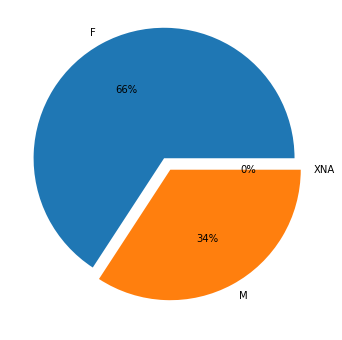

In [10]:
plt.figure(figsize=(10,6))
df_con=pd.DataFrame(data=df["gender"].value_counts())
df_con=df_con.reset_index()
plt.pie(df_con["gender"], labels=df_con["index"],explode=[0.1,0.0,0.0],autopct='%1.0f%%')
plt.show()

**"XNA"** does **not** have **significant** values or contribution ot the dataset.
>Suprisingly, the **dominant** values are of **female** class which proves out to be a positive change in the society as more females are getting the opportunity of securing their income.

#### 2.1.1.2 Owns a Car

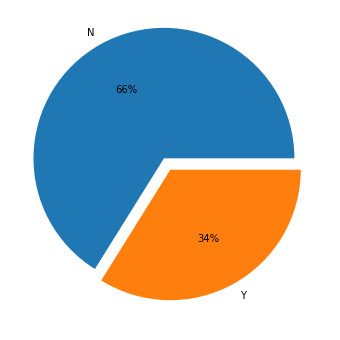

In [11]:
plt.figure(figsize=(10,6))
df_con=pd.DataFrame(data=df["owns_car"].value_counts())
df_con=df_con.reset_index()
plt.pie(df_con["owns_car"], labels=df_con["index"],explode=[0.1,0.0],autopct='%1.0f%%')
plt.show()

**Mostly** people do **not own a car**.
> It reflects that car being conisdered as a luxury item does not limits people's ability to secure their money in a bank account which is good for the society and the bank is doing a great job.

#### 2.1.1.3 Owns a House

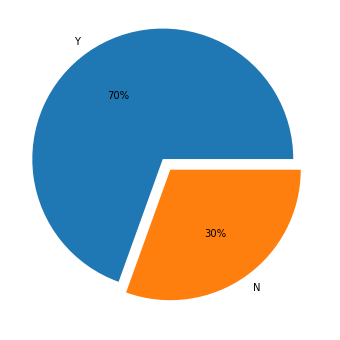

In [12]:
plt.figure(figsize=(10,6))
df_con=pd.DataFrame(data=df["owns_house"].value_counts())
df_con=df_con.reset_index()
plt.pie(df_con["owns_house"], labels=df_con["index"],explode=[0.1,0.0],autopct='%1.0f%%')
plt.show()

**Mostly** people do **own a house**.
> But around 30% of them who do not own it(considered a basic neccesity) still have a bank account. It is a commendable increase in numbers since the last 10 years.

#### 2.1.1.4 Occupation Type

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

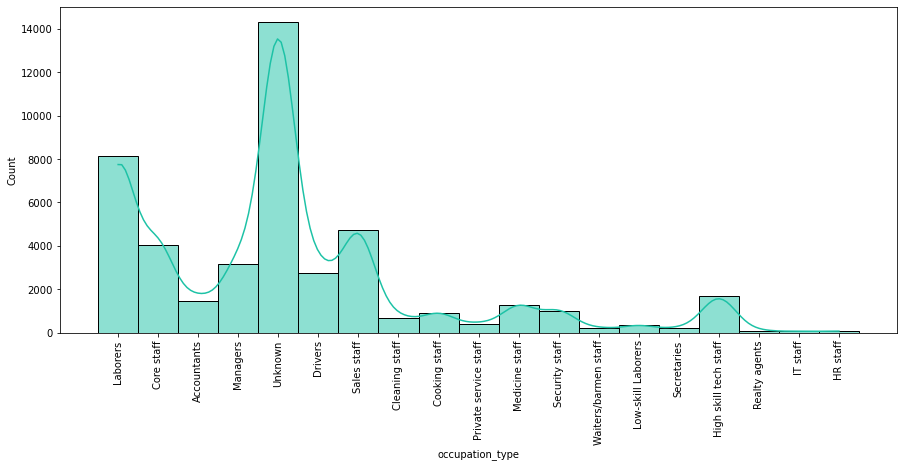

In [13]:
plt.figure(figsize=(15,6))
sns.histplot(data=df["occupation_type"], x=df["occupation_type"], element="bars",kde=True, color="#1dc2a6")
plt.xticks(rotation = 90)

1. **Maximum** people lie in the occupation type **"unknown"**. This needs to be handles sepeartaely.
2. The next most **prominent** occupation is of **labourer**.
> It is a plus point as labourers **being considered as not capable** of having a bank account are the ones with the **most contrbuting customers** of the bank. This is **improving the economy** of the country.

### 2.1.2 According to our inference.

#### 2.1.2.1 Migrant Worker

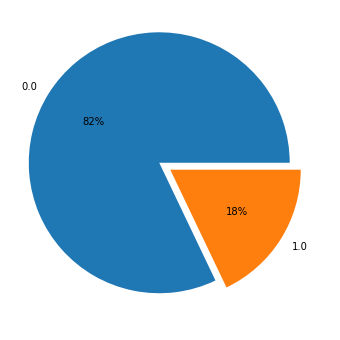

In [14]:
plt.figure(figsize=(10,6))
df_con=pd.DataFrame(data=df["migrant_worker"].value_counts())
df_con=df_con.reset_index()
plt.pie(df_con["migrant_worker"], labels=df_con["index"],explode=[0.1,0.0],autopct='%1.0f%%')
plt.show()

**Most** of the population comes under the category of **migrant workers** as people are always in search of **better paying jobs** and keep in looking after them.

#### 2.1.2.2 Previous Defaults

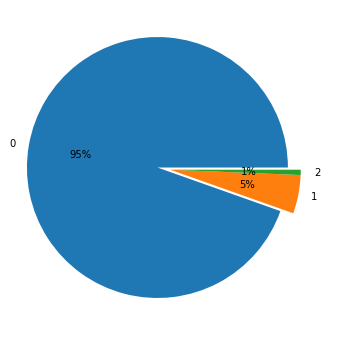

In [15]:
plt.figure(figsize=(10,6))
df_con=pd.DataFrame(data=df["prev_defaults"].value_counts())
df_con=df_con.reset_index()
plt.pie(df_con["prev_defaults"], labels=df_con["index"],explode=[0.1,0.0,0.0],autopct='%1.0f%%')
plt.show()

1. **Most** of the people do **not have previous defaults** which is a good thing as it will increase their credit score.
2. Only **5%** of the population has **1 previous default**.
3. Only **1%** of the population has **2 previous defaults**.
> The **citizens** of the country are **responsible** and do understand the necessity of **maintaining** there bank accounts.

#### 2.1.2.3 Defaults in last 6 months

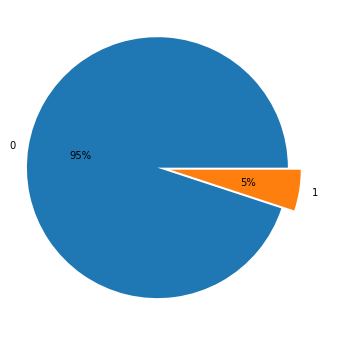

In [16]:
plt.figure(figsize=(10,6))
df_con=pd.DataFrame(data=df["default_in_last_6months"].value_counts())
df_con=df_con.reset_index()
plt.pie(df_con["default_in_last_6months"], labels=df_con["index"],explode=[0.1,0.0],autopct='%1.0f%%')
plt.show()

The metrics over here are same as in the above column as **95%** of people have **no defaults** in the **last 6 months** and only **5%** of them do **have**.

#### 2.1.2.4 Credit card default

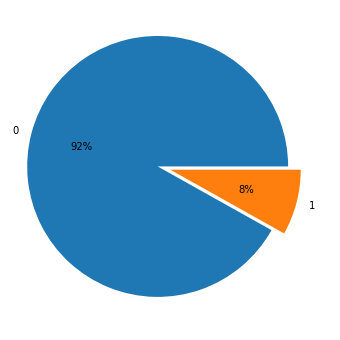

In [17]:
plt.figure(figsize=(10,6))
df_con=pd.DataFrame(data=df["credit_card_default"].value_counts())
df_con=df_con.reset_index()
plt.pie(df_con["credit_card_default"], labels=df_con["index"],explode=[0.1,0.0],autopct='%1.0f%%')
plt.show()

**92%** of the population does **not** have a **credit card default** and only **8%** of them **have** it.

### 2.1.3 Scope of being Categoircal

#### 2.1.3.1 No of Children

<AxesSubplot:xlabel='no_of_children', ylabel='Count'>

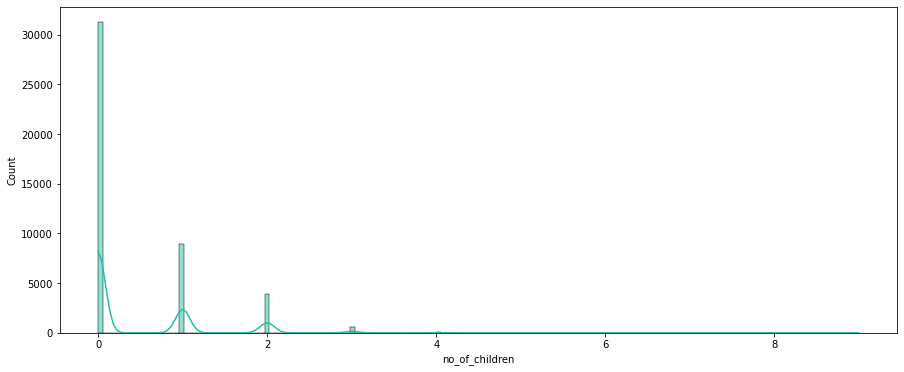

In [18]:
plt.figure(figsize=(15,6))
sns.histplot(data=df["no_of_children"], x=df["no_of_children"], element="bars",kde=True, color="#1dc2a6")

1. This can be divided into **two catgeories**:
    * Either people have **0 children**.
    * **Or more** than that.

As 0 is the mode of the data.

#### 2.1.3.2 Total Fmaily Members

<AxesSubplot:xlabel='total_family_members', ylabel='Count'>

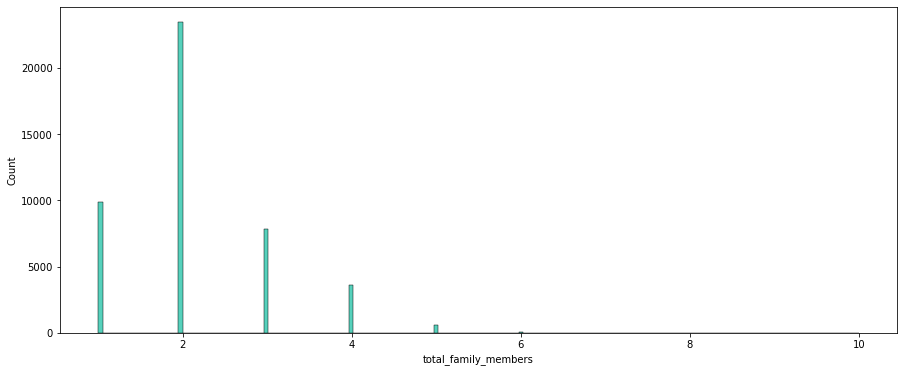

In [19]:
plt.figure(figsize=(15,6))
sns.histplot(data=df["total_family_members"], x=df["total_family_members"], element="bars", color="#1dc2a6")

1. This can be divided into **two catgeories**:
    * Either people have **2 or less family members**.
    * **Or more** than that.

As 2 is the mode of the data.

#### 2.1.3.3 Credit Score

<AxesSubplot:xlabel='credit_score', ylabel='Count'>

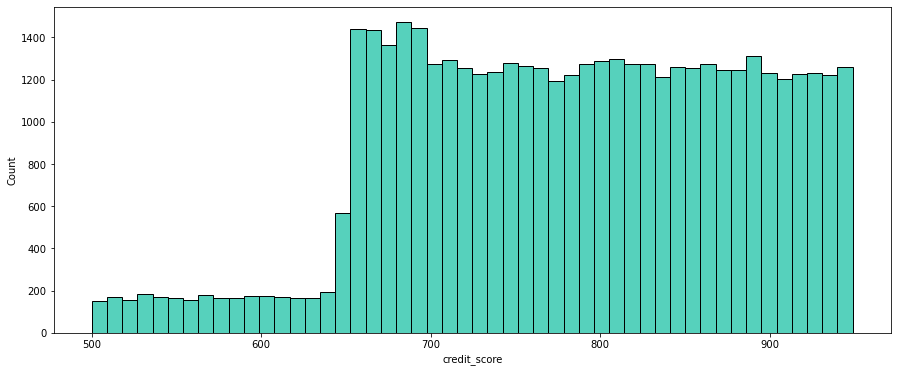

In [20]:
plt.figure(figsize=(15,6))
sns.histplot(data=df["credit_score"], x=df["credit_score"], element="bars", color="#1dc2a6")

1. This can be divided into **two catgeories**:
    * Either people have **<=650**.
    * **Or more** than that.

## 2.2 Visualising Numerical Columns

### 2.2.1 Age

<AxesSubplot:xlabel='age', ylabel='Count'>

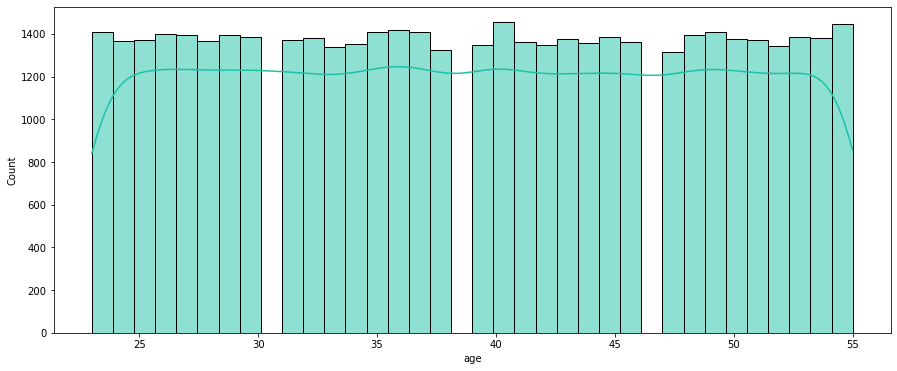

In [21]:
plt.figure(figsize=(15,6))
sns.histplot(data=df["age"], x=df["age"], element="bars",kde=True, color="#1dc2a6")

### 2.2.2 Net yearly income

<AxesSubplot:xlabel='net_yearly_income', ylabel='Count'>

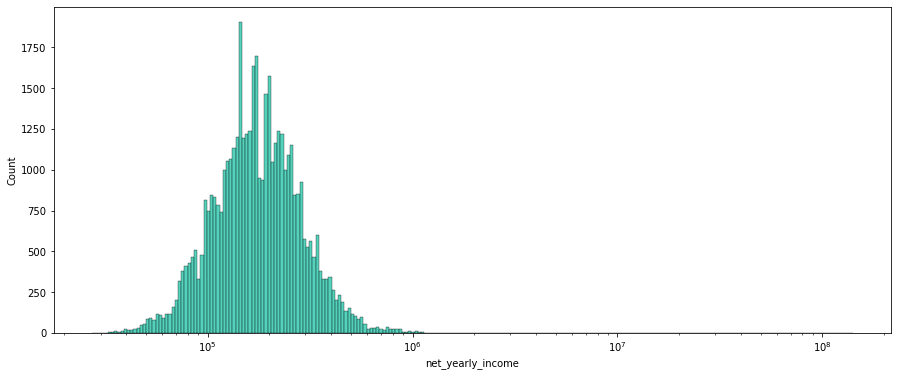

In [22]:
plt.figure(figsize=(15,6))
sns.histplot(data=df["net_yearly_income"], x=df["net_yearly_income"], element="bars", color="#1dc2a6",log_scale=True)

### 2.2.3 No of days employed

<AxesSubplot:xlabel='no_of_days_employed', ylabel='Count'>

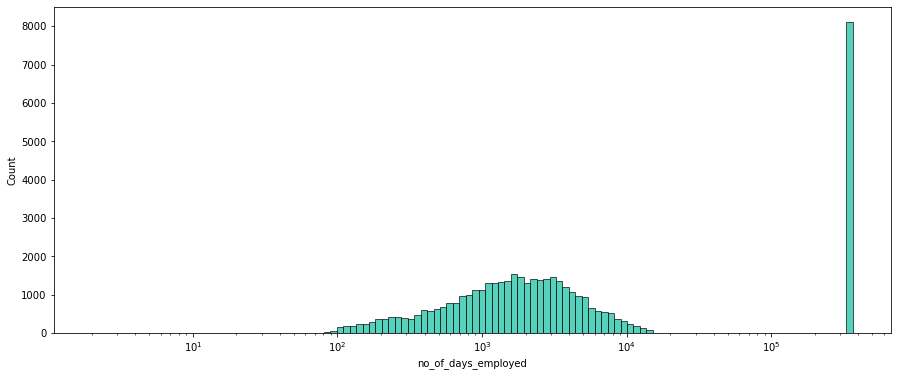

In [23]:
plt.figure(figsize=(15,6))
sns.histplot(data=df["no_of_days_employed"], x=df["no_of_days_employed"], element="bars", color="#1dc2a6",log_scale=True)

**Most** of the people are employed for **more than 1,00,000 days** which equals to around **273 years** and is impractical. Hence, it is an **outlier** which needs to be handled.

### 2.2.4 Yearly debt payments

<AxesSubplot:xlabel='yearly_debt_payments', ylabel='Count'>

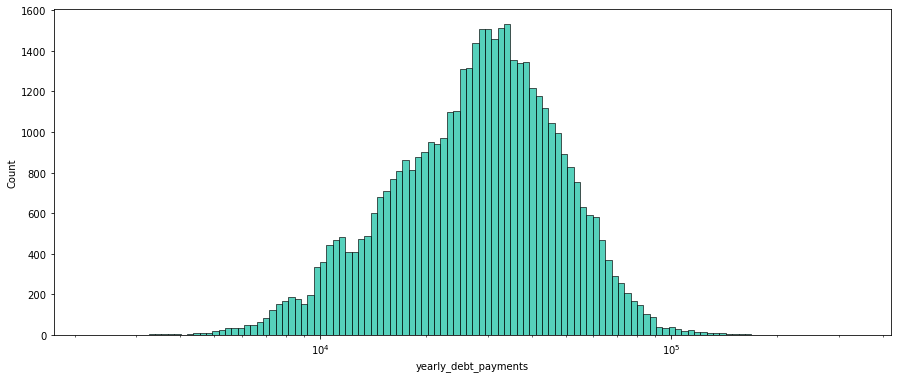

In [24]:
plt.figure(figsize=(15,6))
sns.histplot(data=df["yearly_debt_payments"], x=df["yearly_debt_payments"], element="bars", color="#1dc2a6",log_scale=True)

### 2.2.5 Credit Limit

<AxesSubplot:xlabel='credit_limit', ylabel='Count'>

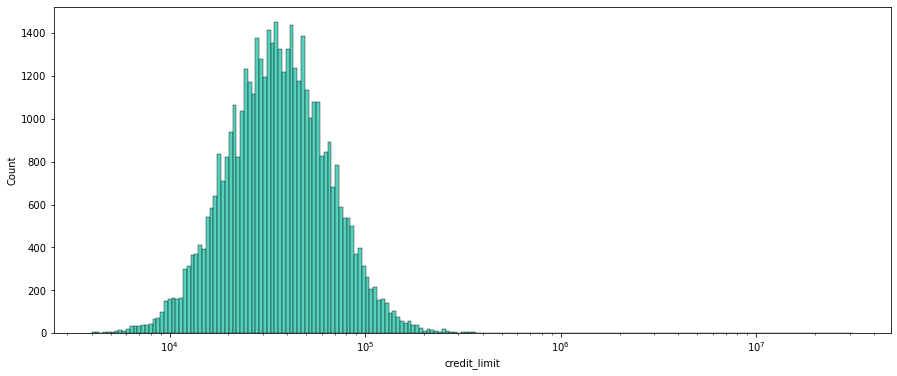

In [25]:
plt.figure(figsize=(15,6))
sns.histplot(data=df["credit_limit"], x=df["credit_limit"], element="bars", color="#1dc2a6",log_scale=True)

### 2.2.6 Credit Limit Used (%)

<AxesSubplot:xlabel='credit_limit_used(%)', ylabel='Count'>

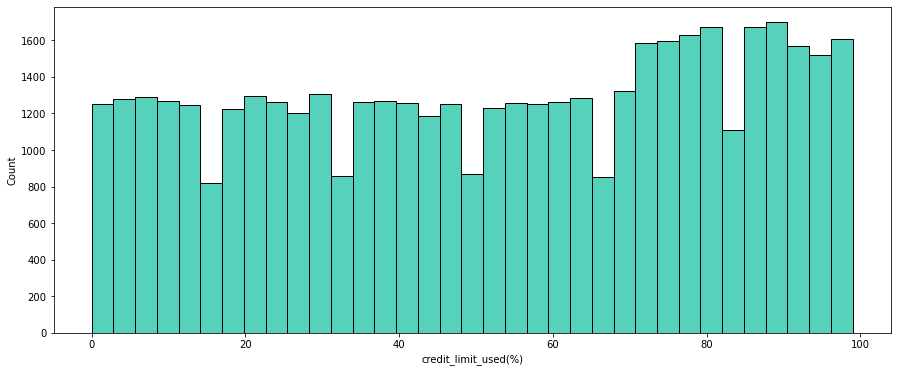

In [26]:
plt.figure(figsize=(15,6))
sns.histplot(data=df["credit_limit_used(%)"], x=df["credit_limit_used(%)"], element="bars", color="#1dc2a6")

## 2.3 Visualizing Correlated Columns

### 2.3.1 Finding Correlations

<AxesSubplot:>

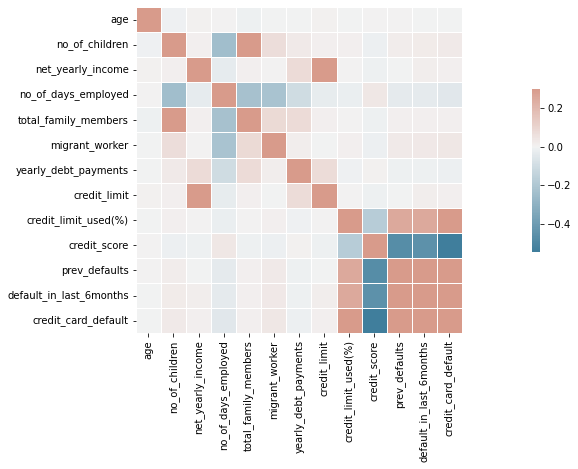

In [27]:
plt.figure(figsize=(25,6))
sns.heatmap(df.corr(),cmap=sns.diverging_palette(230, 20, as_cmap=True),vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

### 2.3.2 Filtering Significant Correlations

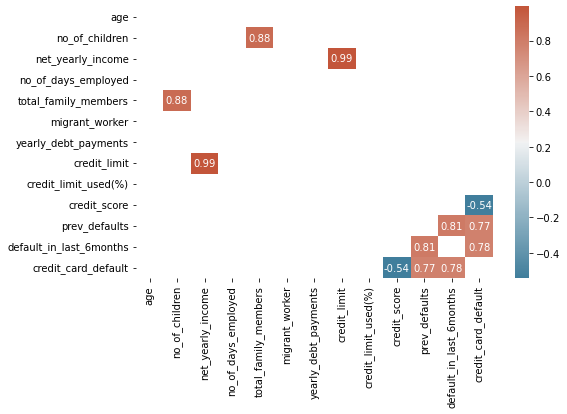

In [28]:
dfCorr = df.corr()
filteredDf = dfCorr[((dfCorr >= .5) | (dfCorr <= -.5)) & (dfCorr !=1.000)]
plt.figure(figsize=(8,5))
sns.heatmap(filteredDf, annot=True, cmap=sns.diverging_palette(230, 20, as_cmap=True))
plt.show()

#### 2.3.2.1 Credit Limit & Net Yearly Income

**Converting** values to **logarithmic** forms for better visualization.

In [29]:
df["credit_limit"]=np.log(df["credit_limit"])
df["net_yearly_income"]=np.log(df["net_yearly_income"])

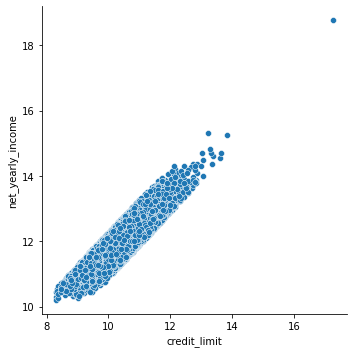

In [30]:
sns.relplot(data=df, x=df.credit_limit, y=df.net_yearly_income)

Both of the columns are highly correlated and almost same.
>It is obvious that a person having more income is expected to have more credit limit.

#### 2.3.2.2 No. of Children & Total family members

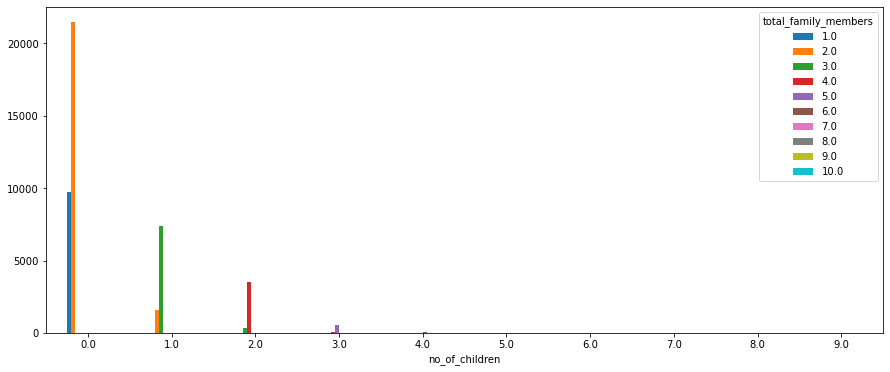

In [31]:
crosstb = pd.crosstab(df.no_of_children,df["total_family_members"])
barplot = crosstb.plot.bar(rot=0,figsize = (15,6))
plt.show()

    No of children : Family Members

            0      :      1/2
       
            1      :      2/3
       
            2      :      3/4
       
            3      :      5/7
> In maximum cases people do **not have a child** and there are **two family members**. If they do have **1 child**, they become **three**.

#### 2.3.2.3 Default in last 6 months & Prev Defaults

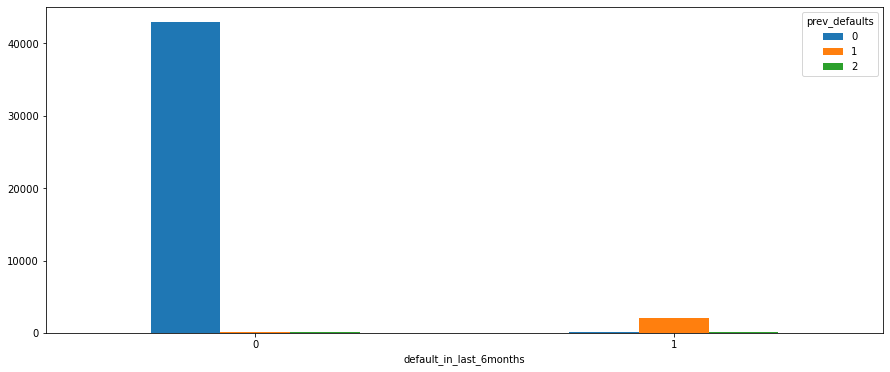

In [32]:
crosstb = pd.crosstab(df["default_in_last_6months"], df.prev_defaults)
barplot = crosstb.plot.bar(rot=0,figsize = (15,6))
plt.show()

People who have **0 defaults** in the last **6 months** are likely to **have 0 defaults before** that too.
> Mostly people have 0 defaults.

People who have **1 default** in the last **6 months** have a **few chances** of **having before** it too.

#### 2.3.2.4 Default in last 6 months & Credit card default

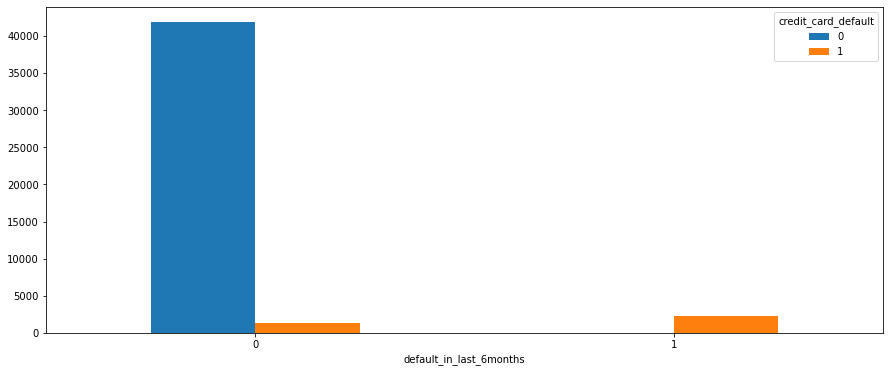

In [33]:
crosstb = pd.crosstab(df["default_in_last_6months"], df.credit_card_default)
barplot = crosstb.plot.bar(rot=0,figsize = (15,6))
plt.show()

There are a **very few chances** of people having **0 defaults** in **last  6 months** to be a **credit card defaulter.**

It is **obvious** that people who **have 1 default** in the last 6 months will be a **credit card defaulter**.

#### 2.3.2.5 Previous defaults & Credit card default

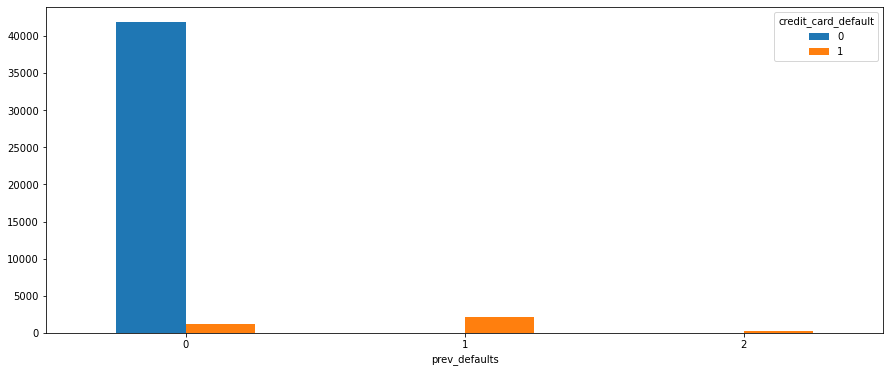

In [34]:
crosstb = pd.crosstab(df["prev_defaults"], df.credit_card_default)
barplot = crosstb.plot.bar(rot=0,figsize = (15,6))
plt.show()

A person having **0 defaults in the past** has a very **few chances** of being a credit card **defaulter** as **compared** to a person **having one or two defaults** in the past.

#### 2.3.2.4 Credit Score & Credit card Default

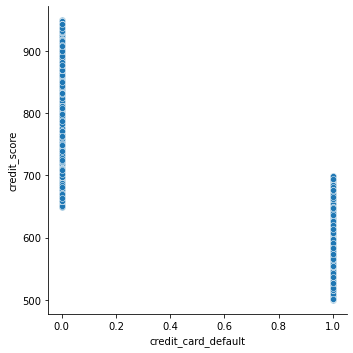

In [35]:
sns.relplot(data=df, y=df["credit_score"], x=df.credit_card_default)

A person having a **credit score of >=650** is likely to have **0 credit card default**.

A person having a **credit score of <700** is likely to have **1 credit card default**.

# 3. Data pre-processing

## 3.1. Grouping columns.

In [36]:
for dataset in [df]:
    dataset.loc[dataset['gender'] == 'F', 'gender'] = 0
    dataset.loc[dataset['gender'] == 'M', 'gender'] = 1
    dataset.loc[dataset['gender'] == 'XNA', 'gender'] = np.nan
    dataset.loc[dataset['owns_car'] == 'N', 'owns_car'] = 0
    dataset.loc[dataset['owns_car'] == 'Y', 'owns_car'] = 1
    dataset.loc[dataset['owns_house'] == 'N', 'owns_house'] = 0
    dataset.loc[dataset['owns_house'] == 'Y', 'owns_house'] = 1
    dataset.loc[dataset['no_of_children'] != 0.0, 'no_of_children'] = 1.0
    dataset.loc[dataset['total_family_members'] <= 2, 'total_family_members'] = 1
    dataset.loc[dataset['total_family_members'] > 2, 'total_family_members'] = 0
    dataset.loc[dataset['credit_score'] <= 650, 'credit_score'] = 0
    dataset.loc[dataset['credit_score'] > 650, 'credit_score'] = 1
    dataset.loc[dataset["occupation_type"] == 'Unknown', "occupation_type"] = np.nan

df=df.drop(["name"],axis=1)
df.head()

,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
customer_id,,,,,,,,,,,,,,,,,
100002,38,1,0,1,0.0,12.311670,640.0,Laborers,1.0,0.0,27216.28,11.281804,81,1.0,0,0,1
100003,38,0,0,0,0.0,12.697135,1190.0,Core staff,1.0,0.0,43498.46,11.373685,89,1.0,0,0,0
100004,32,1,1,1,0.0,11.303254,232.0,Laborers,1.0,0.0,7918.24,9.298724,83,1.0,0,0,0
100006,45,0,0,1,0.0,11.882870,3036.0,Laborers,1.0,0.0,34434.50,9.950935,24,1.0,0,0,0
100007,55,1,0,1,0.0,11.910349,3045.0,Core staff,1.0,1.0,27858.49,10.580886,84,1.0,0,0,0


### 3.2 Checking for data types of columns

In [37]:
df.dtypes

age                          int64
gender                      object
owns_car                    object
owns_house                  object
no_of_children             float64
net_yearly_income          float64
no_of_days_employed        float64
occupation_type             object
total_family_members       float64
migrant_worker             float64
yearly_debt_payments       float64
credit_limit               float64
credit_limit_used(%)         int64
credit_score               float64
prev_defaults                int64
default_in_last_6months      int64
credit_card_default          int64
dtype: object

## 3.3 Handling Missing Values

### 3.3.1 Filling values with mode of columns

In [38]:
df = df.apply(lambda x: x.fillna(x.value_counts().index[0]))
df.head()

,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
customer_id,,,,,,,,,,,,,,,,,
100002,38,1,0,1,0.0,12.311670,640.0,Laborers,1.0,0.0,27216.28,11.281804,81,1.0,0,0,1
100003,38,0,0,0,0.0,12.697135,1190.0,Core staff,1.0,0.0,43498.46,11.373685,89,1.0,0,0,0
100004,32,1,1,1,0.0,11.303254,232.0,Laborers,1.0,0.0,7918.24,9.298724,83,1.0,0,0,0
100006,45,0,0,1,0.0,11.882870,3036.0,Laborers,1.0,0.0,34434.50,9.950935,24,1.0,0,0,0
100007,55,1,0,1,0.0,11.910349,3045.0,Core staff,1.0,1.0,27858.49,10.580886,84,1.0,0,0,0


### 3.3.2 Checking for sum of missing values(if left)

In [39]:
df.isna().sum()

age                        0
gender                     0
owns_car                   0
owns_house                 0
no_of_children             0
net_yearly_income          0
no_of_days_employed        0
occupation_type            0
total_family_members       0
migrant_worker             0
yearly_debt_payments       0
credit_limit               0
credit_limit_used(%)       0
credit_score               0
prev_defaults              0
default_in_last_6months    0
credit_card_default        0
dtype: int64

## 3.4 Encoding Columns

In [40]:
le = LabelEncoder()
df["occupation_type"] = le.fit_transform(df["occupation_type"])
df = df.astype(int)

## 3.5 Checking data types

In [41]:
df.dtypes

age                        int64
gender                     int64
owns_car                   int64
owns_house                 int64
no_of_children             int64
net_yearly_income          int64
no_of_days_employed        int64
occupation_type            int64
total_family_members       int64
migrant_worker             int64
yearly_debt_payments       int64
credit_limit               int64
credit_limit_used(%)       int64
credit_score               int64
prev_defaults              int64
default_in_last_6months    int64
credit_card_default        int64
dtype: object

All columns have been converted to the same data type.

# 4. Model Development & Classification

## 4.1 Data preparation

We will **drop** the three highly **positively correlated** columns with the target variable so as to **avoid multicollinearity**.

In [42]:
X= df.drop(['credit_limit_used(%)', 'prev_defaults','default_in_last_6months', 'credit_card_default'],axis=1)
y=df['credit_card_default']
y.value_counts(normalize=True)

0    0.918797
1    0.081203
Name: credit_card_default, dtype: float64

We need to do **sampling** to **remove bias** in training model.

In [43]:
rs = RandomOverSampler(random_state=30)
rs.fit(X,y)

RandomOverSampler(random_state=30)

In [44]:
X_new,y_new = rs.fit_resample(X, y)
y_new.value_counts(normalize=True)

1    0.5
0    0.5
Name: credit_card_default, dtype: float64

## 4.2 Training the dataset

In [45]:
split_size=0.3

#Creation of Train and Test dataset
X_train, X_test, y_train, y_test = train_test_split(X_new,y_new,test_size=split_size,random_state=22)

#Creation of Train and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=5)

In [46]:
print ("Train dataset: {0}{1}".format(X_train.shape, y_train.shape))
print ("Validation dataset: {0}{1}".format(X_val.shape, y_val.shape))
print ("Test dataset: {0}{1}".format(X_test.shape, y_test.shape))

Train dataset: (46850, 13)(46850,)
Validation dataset: (11713, 13)(11713,)
Test dataset: (25099, 13)(25099,)


## 4.3 Model Developement

### 4.3.1 Initiating the model

In [47]:
models = []
names = ['Random Forest','GaussianNB','DecisionTreeClassifier','Adaboost','Xgboost','LGBM']

models.append((RandomForestClassifier(n_estimators=100)))
models.append((GaussianNB()))
models.append((DecisionTreeClassifier()))
models.append((AdaBoostClassifier()))
models.append((xgb.XGBClassifier()))
models.append((ltb.LGBMClassifier()))

### 4.3.2 Cross-vaildating models & choosing best fit.

In [48]:
kfold = KFold(n_splits=5)
for i in range(0,len(models)):    
    cv_result = cross_val_score(models[i],X_train,y_train,cv=kfold,scoring='accuracy')
    score=models[i].fit(X_train,y_train)
    prediction = models[i].predict(X_val)
    acc_score = accuracy_score(y_val,prediction)     
    print ('-'*40)
    print ('{0}: {1}'.format(names[i],acc_score))

----------------------------------------
Random Forest: 0.997524118500811
----------------------------------------
GaussianNB: 0.5487919405788441
----------------------------------------
DecisionTreeClassifier: 0.9781439426278494
----------------------------------------
Adaboost: 0.8786818065397421
----------------------------------------
Xgboost: 0.9390420899854862
----------------------------------------
LGBM: 0.8960129770340647


**Random Forest Classifier** gets selected as it has the **maximum accuracy score**.

## 4.4 Testing the dataset

In [49]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
prediction = rf.predict(X_test)
print ('-'*40)
print ('Accuracy score:')
print (accuracy_score(y_test,prediction))
print ('-'*40)
print ('Confusion Matrix:')
print (confusion_matrix(y_test,prediction))
print ('-'*40)
print ('Classification Matrix:')
print (classification_report(y_test,prediction))

----------------------------------------
Accuracy score:
0.9976094665126101
----------------------------------------
Confusion Matrix:
[[12474    60]
 [    0 12565]]
----------------------------------------
Classification Matrix:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12534
           1       1.00      1.00      1.00     12565

    accuracy                           1.00     25099
   macro avg       1.00      1.00      1.00     25099
weighted avg       1.00      1.00      1.00     25099

